定义数据加载方式

In [1]:
import os
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms

transform2=transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

transform = transforms.Compose([
    transforms.Resize((256, 256)), 
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 标准化
])

class MyDataset(Dataset):
    def __init__(self,path1,path2,path3):
        self.path_seg=path1
        self.name_seg=os.listdir(os.path.join(path1,''))
        self.path_img=path2
        self.name_img=os.listdir(os.path.join(path2,''))
        self.path_w=path3
        self.name_w=os.listdir(os.path.join(path3,''))

    def __len__(self):
        return len(self.name_seg)

    def __getitem__(self, index):
        segment_name=self.name_seg[index]  
        segment_path=os.path.join(self.path_seg,'',segment_name)
        img_name=self.name_img[index] 
        img_path=os.path.join(self.path_img,'',img_name)
        w_name=self.name_w[index]
        w_path=os.path.join(self.path_w,'',w_name)

        # 打开标签
        segment_image=Image.open(segment_path).convert("L")
        # 打开原图
        image=Image.open(img_path).convert('RGB')
        # 打开权重
        w=Image.open(w_path).convert("L")

            
        return transform(image),transform2(segment_image),transform2(w)

加载数据

In [2]:
from torch import nn,optim
import torch
from torch.utils.data import DataLoader
from torchvision.utils import save_image

data_path1='/Users/apple/Desktop/李广能/unet3.0/unet/data/SegmentationClass'
data_path2='/Users/apple/Desktop/李广能/unet3.0/unet/data/JPEGImages'
data_path3="/Users/apple/Desktop/李广能/unet3.0/unet/data/权重"

data_loader=DataLoader(MyDataset(data_path1,data_path2,data_path3),batch_size=10,shuffle=False)

展示数据,依次为原图，标签，权重

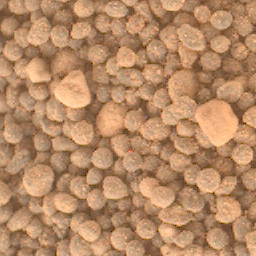

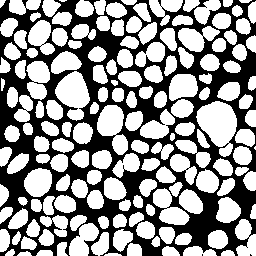

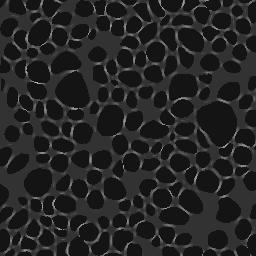

In [3]:

from IPython.display import display

display(Image.open("/Users/apple/Desktop/李广能/unet3.0/unet/data/JPEGImages/3sch0716_origin.png"))
display(Image.open("/Users/apple/Desktop/李广能/unet3.0/unet/data/SegmentationClass/3sch0716_origin.png"))
display(Image.open("/Users/apple/Desktop/李广能/unet3.0/unet/data/权重/3sch0716_origin.jpg"))


定义网络结构

In [4]:
from torch import nn
from torch.nn import functional as F
from IPython.display import display

class Conv_Block(nn.Module):
    def __init__(self,in_channel,out_channel):
        super(Conv_Block, self).__init__()
        self.layer=nn.Sequential(
            nn.Conv2d(in_channel,out_channel,3,1,1,padding_mode='reflect',bias=False),
            nn.BatchNorm2d(out_channel),
            nn.Dropout2d(0.01),
            nn.LeakyReLU(),
            nn.Conv2d(out_channel,out_channel,3, 1, 1, padding_mode='reflect', bias=False),
            nn.BatchNorm2d(out_channel),
            nn.Dropout2d(0.01),
            nn.LeakyReLU()
        )
    def forward(self,x):
        return self.layer(x)


class DownSample(nn.Module):
    def __init__(self,channel):
        super(DownSample, self).__init__()
        self.layer=nn.Sequential(
            nn.Conv2d(channel,channel,3,2,1,padding_mode='reflect',bias=False),
            nn.BatchNorm2d(channel),
            nn.LeakyReLU()
        )
    def forward(self,x):
        return self.layer(x)


class UpSample(nn.Module):
    def __init__(self,channel):
        super(UpSample, self).__init__()
        self.layer=nn.Conv2d(channel,channel,1,1)
    def forward(self,x,feature_map):
        up=F.interpolate(x,scale_factor=2,mode='nearest')
        out=self.layer(up)
        return torch.cat((out,feature_map),dim=1)


class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.c1=Conv_Block(3,5)
        self.d1=DownSample(5)
        self.c2=Conv_Block(5,20)
        self.d2=DownSample(5)
        self.c3=Conv_Block(5,5)
        self.d3=DownSample(5)
        self.c4=Conv_Block(5,5)
        self.d4=DownSample(5)
        self.c5=Conv_Block(5,5)
        self.u1=UpSample(5)
        self.c6=Conv_Block(10,5)
        self.u2 = UpSample(5)
        self.c7 = Conv_Block(10, 5)
        self.u3 = UpSample(5)
        self.c8 = Conv_Block(10, 5)
        self.u4 = UpSample(20)
        self.c9 = Conv_Block(25, 5)
        self.out=nn.Conv2d(5,1,3,1,1)
        self.Th=nn.Sigmoid()

    def forward(self,x):
        R1=self.c1(x)
        R2=self.c2(self.d1(R1))
        # R3 = self.c3(self.d2(R2))
        # R4 = self.c4(self.d3(R3))
        # R5 = self.c5(self.d4(R4))
        # O1=self.c6(self.u1(R5,R4))
        # O2 = self.c7(self.u2(O1, R3))
        # O3 = self.c8(self.u3(O2, R2))
        O4 = self.c9(self.u4(R2, R1))
        return self.Th(self.out(O4))


训练网络

成功加载模型数据
0-0-train_loss===>>0.055737484246492386


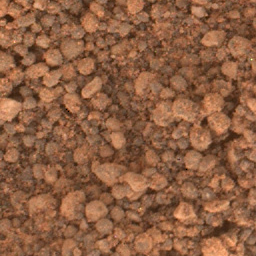

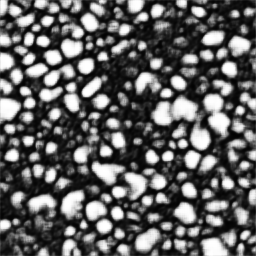

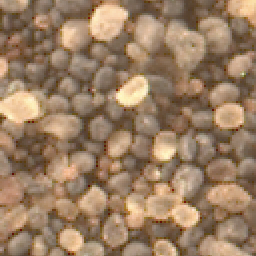

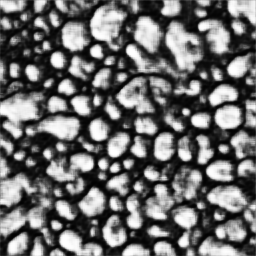

0-2-train_loss===>>0.05692235007882118


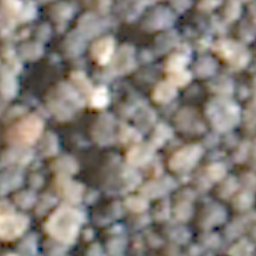

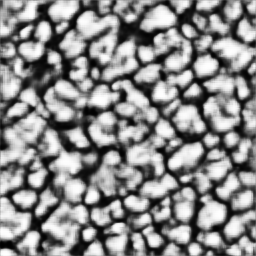

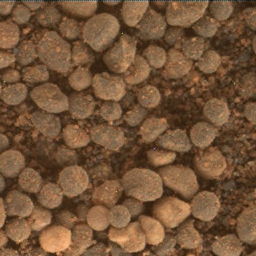

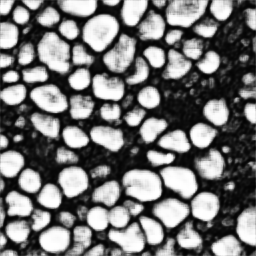

0-4-train_loss===>>0.06230807304382324


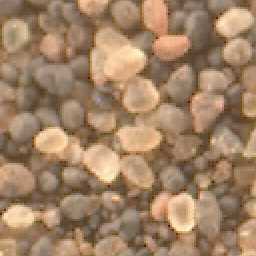

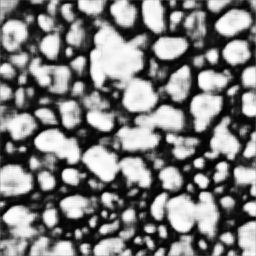

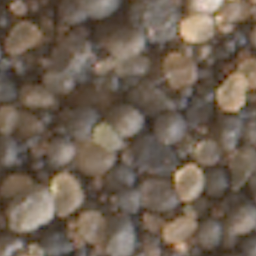

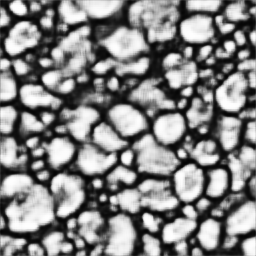

1-0-train_loss===>>0.06419825553894043


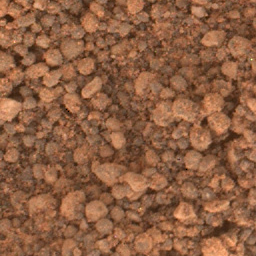

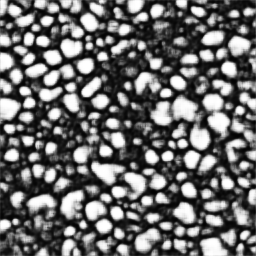

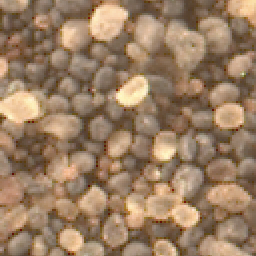

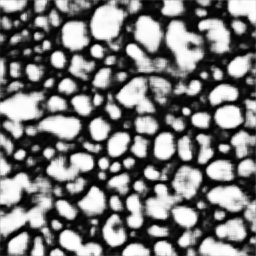

1-2-train_loss===>>0.05700011923909187


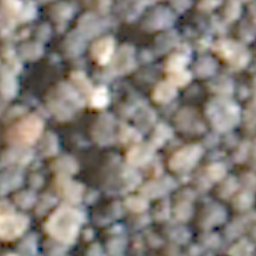

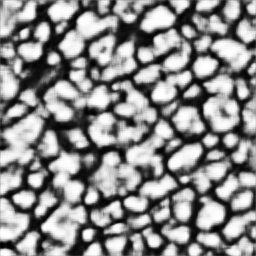

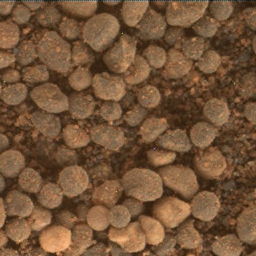

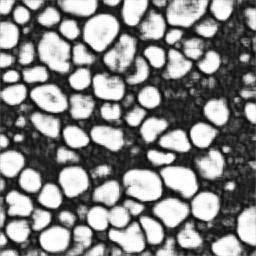

1-4-train_loss===>>0.06621675938367844


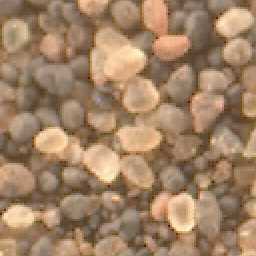

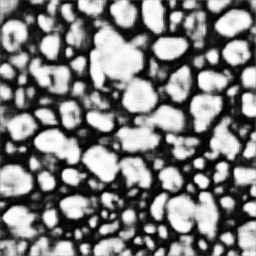

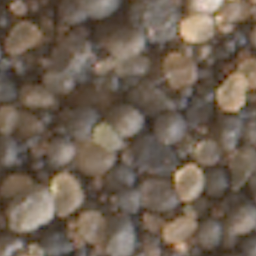

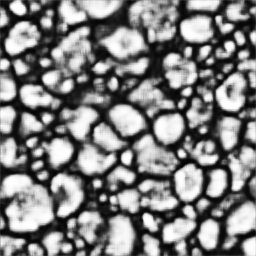

2-0-train_loss===>>0.06387853622436523


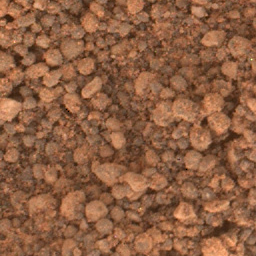

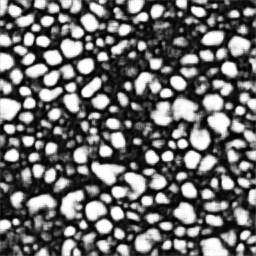

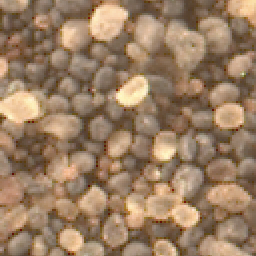

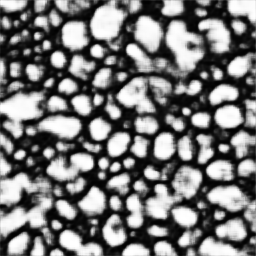

2-2-train_loss===>>0.052174896001815796


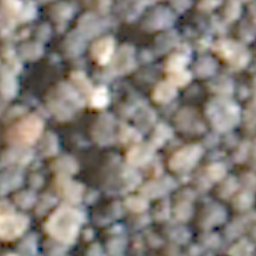

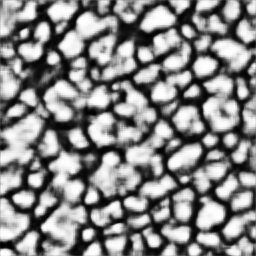

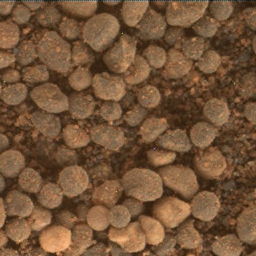

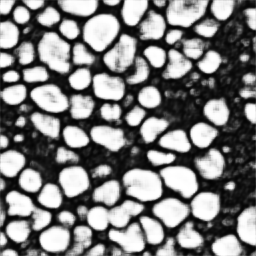

2-4-train_loss===>>0.0698288232088089


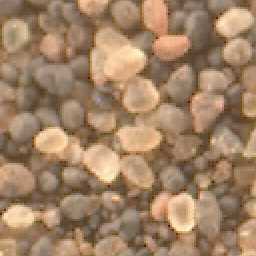

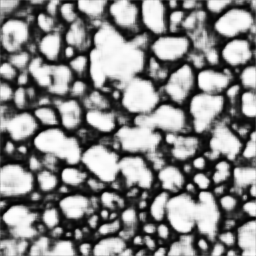

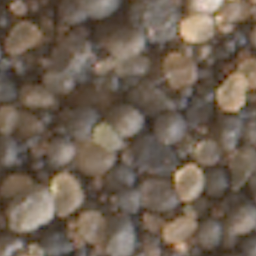

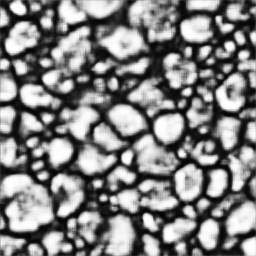

3-0-train_loss===>>0.059701889753341675


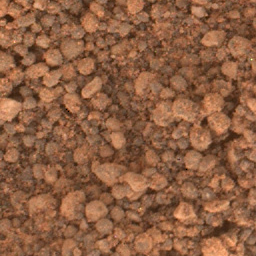

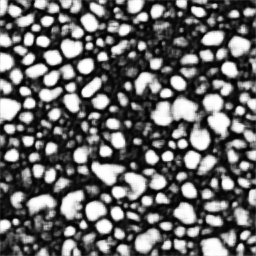

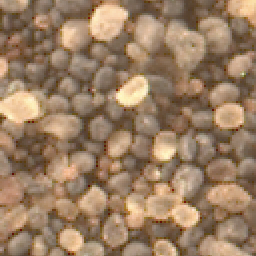

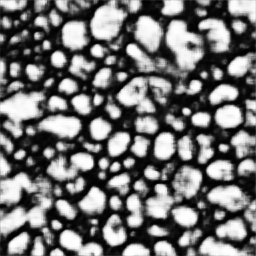

3-2-train_loss===>>0.0525786392390728


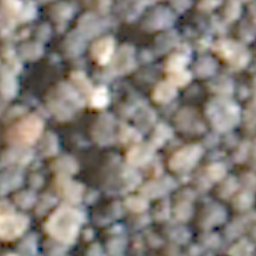

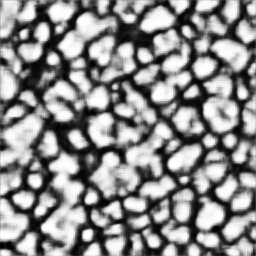

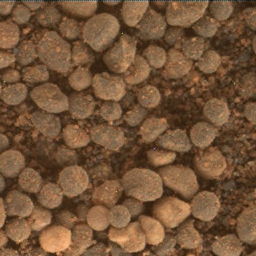

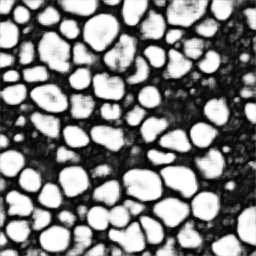

3-4-train_loss===>>0.07068104296922684


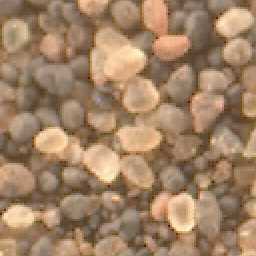

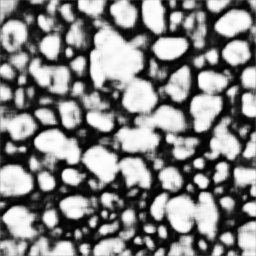

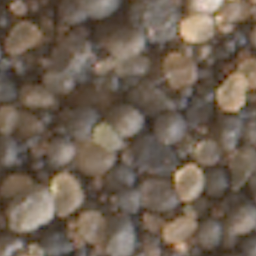

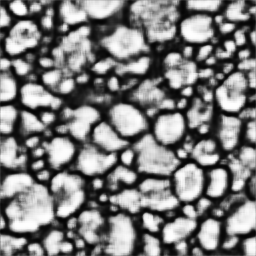

4-0-train_loss===>>0.05672137066721916


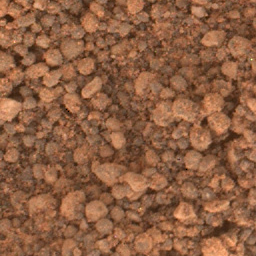

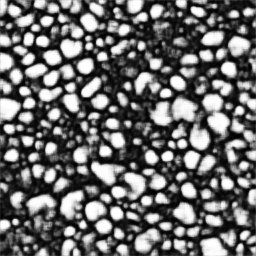

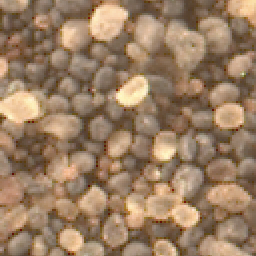

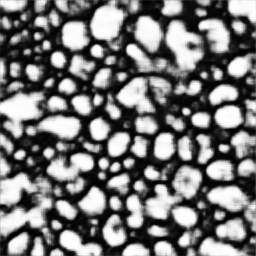

4-2-train_loss===>>0.053881991654634476


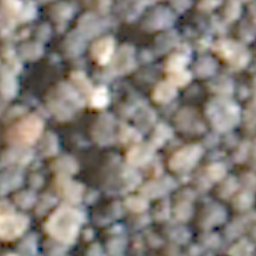

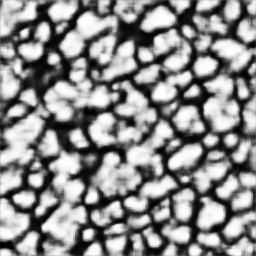

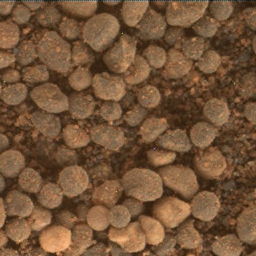

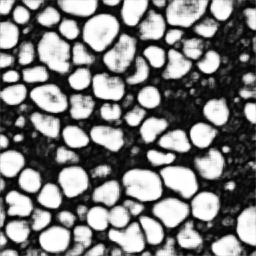

4-4-train_loss===>>0.06100817397236824


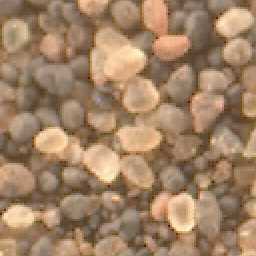

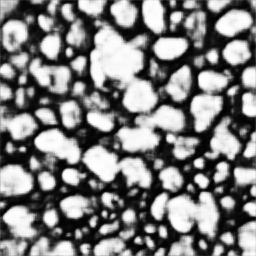

KeyboardInterrupt: 

In [5]:
from torch import nn,optim
from torch.utils.data import DataLoader
from torchvision.utils import save_image
import torchvision.transforms as transforms
import numpy as np

device=torch.device("mps")
weight_path='params/默认.pth'
save_path='train_image'

net= UNet().to(device)
opt=optim.NAdam(net.parameters(),lr=1e-2)

if os.path.exists(weight_path):
    net.load_state_dict(torch.load(weight_path))
    print('成功加载模型数据')
else:
    print('没有成功加载数据！已新建')

for j in range(300):
     for i,(image,segment_image,w) in enumerate(data_loader):
        image, segment_image,w=image.to(device),segment_image.to(device),w.to(device)
        loss_fun = nn.BCELoss(weight=w)
        out_image=net(image)
        train_loss=loss_fun(out_image,segment_image)
        opt.zero_grad()
        train_loss.backward()
        opt.step()

        if i%2==0:
            print(f'{j}-{i}-train_loss===>>{train_loss.item()}')

        if i%2==0:
            torch.save(net.state_dict(),weight_path)

        
        _image=image[0]
        _out_image=out_image[0]

        save_image(_image,f'{save_path}/{i}-img.png')
        save_image(_out_image,f'{save_path}/{i}-out.png')
         
        display(Image.open(f'{save_path}/{i}-img.png'))
        display(Image.open(f'{save_path}/{i}-out.png'))
    


